# 06 - Generalização em Machine Learning

Neste notebook, vamos explorar um dos conceitos mais importantes em machine learning: **generalização**. Veremos como os modelos se comportam quando expostos a dados que não viram durante o treinamento e como evitar problemas como overfitting e underfitting.

## Objetivos de Aprendizagem

Ao final deste notebook, você será capaz de:
- Compreender os conceitos de overfitting, underfitting e bias-variance tradeoff
- Implementar modelos polinomiais usando PyTorch para demonstrar estes conceitos
- Analisar curvas de treinamento para identificar problemas de generalização
- Aplicar técnicas de validação em datasets reais (Fashion-MNIST)

## Importações

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuração para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cpu


## 1. Conceitos Fundamentais de Generalização

### 1.1 Definições

**Generalização** é a capacidade de um modelo de fazer predições precisas em dados que não foram vistos durante o treinamento.

**Overfitting (Sobreajuste)**: O modelo aprende os dados de treinamento muito bem, incluindo ruído e detalhes específicos, mas falha em generalizar para novos dados.

**Underfitting (Subajuste)**: O modelo é muito simples para capturar os padrões subjacentes nos dados, resultando em performance ruim tanto no treinamento quanto na validação.

### 1.2 Bias-Variance Tradeoff

O erro total de um modelo pode ser decomposto em três componentes:

$$\text{Erro Total} = \text{Bias}^2 + \text{Variância} + \text{Ruído}$$

- **Bias**: Erro devido a suposições simplificadas no algoritmo de aprendizagem
- **Variância**: Erro devido à sensibilidade a pequenas flutuações no conjunto de treinamento
- **Ruído**: Erro irredutível nos dados

![Bias-Variance Tradeoff](https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg)

## 2. Demonstração com Regressão Polinomial

Vamos criar um exemplo prático usando regressão polinomial para demonstrar overfitting e underfitting.

### 2.1 Classe Polinomial Customizada

In [2]:
class PolynomialRegressor(nn.Module):
    """Modelo de regressão polinomial usando PyTorch.

    Implementa um polinômio de grau n:
    y = a_0 + a_1*x + a_2*x^2 + ... + a_n*x^n
    """

    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        # Coeficientes do polinômio (parâmetros aprendíveis)
        self.coefficients = nn.Parameter(torch.randn(degree + 1))

    def forward(self, x):
        """Forward pass: calcula o polinômio para os valores de entrada."""
        # Criar matriz de potências [1, x, x^2, x^3, ..., x^n]
        powers = torch.stack([x.squeeze()**i for i in range(self.degree + 1)], dim=1)
        # Calcular y = sum(a_i * x^i)
        return torch.sum(powers * self.coefficients, dim=1, keepdim=True)

    def get_coefficients(self):
        """Retorna os coeficientes aprendidos."""
        return self.coefficients.detach().numpy()

# Testar a classe
model = PolynomialRegressor(degree=2)
x_test = torch.linspace(-2, 2, 10).unsqueeze(1)
y_test = model(x_test)
print(f'Forma da entrada: {x_test.shape}')
print(f'Forma da saída: {y_test.shape}')
print(f'Coeficientes iniciais: {model.get_coefficients()}')

Forma da entrada: torch.Size([10, 1])
Forma da saída: torch.Size([10, 1])
Coeficientes iniciais: [-0.7393585 -0.4297941  0.5487088]


### 2.2 Geração de Dados Sintéticos

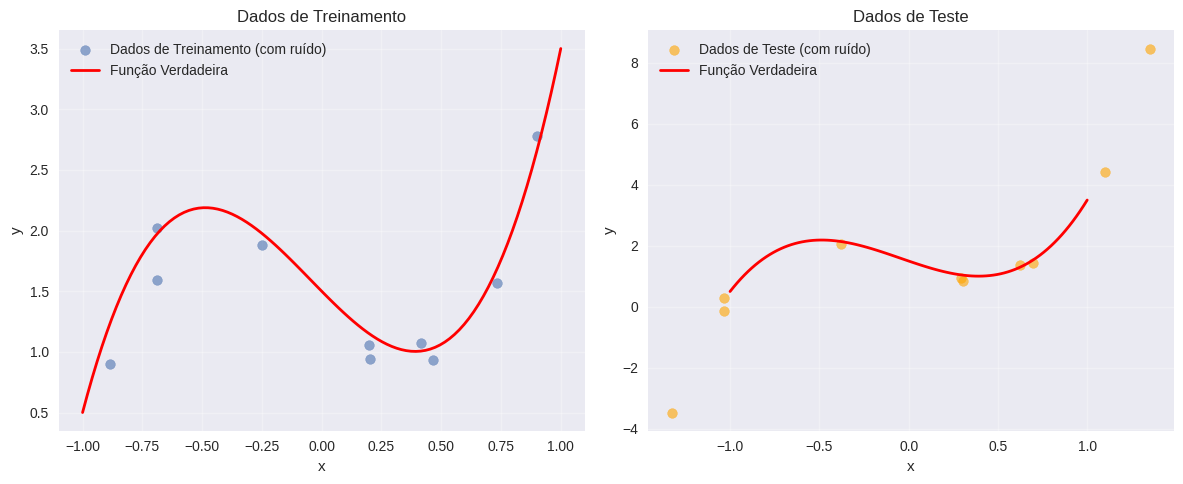

Tamanho do conjunto de treinamento: 10
Tamanho do conjunto de teste: 10


In [3]:
def generate_data(true_func, n_samples=100, noise_std=0.3, x_range=(-2, 2), seed=42, offset=0.0):
    """Gera dados com base em uma função verdadeira e adiciona ruído."""
    np.random.seed(seed)

    x = np.random.uniform(x_range[0]-offset, x_range[1]+offset, n_samples)
    y_true = true_func(x)
    noise = np.random.normal(0, noise_std, n_samples)
    y_noisy = y_true + noise

    return x, y_true, y_noisy

# Definir função verdadeira (parábola)
def true_polynomial(x):
    return 1.5 - 2.0 * x + 0.5 * x**2 + 3.5 * x**3

x_range = (-1, 1)
noise_std = 0.2
test_offset = 0.5

# Gerar dados
x_train, y_train_true, y_train_noisy = generate_data(true_polynomial, n_samples=10, noise_std=noise_std, x_range=x_range)
x_test, y_test_true, y_test_noisy = generate_data(true_polynomial, n_samples=10, noise_std=noise_std, x_range=x_range, offset=test_offset)

# Converter para tensores
x_train_tensor = torch.FloatTensor(x_train).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train_noisy).unsqueeze(1)
x_test_tensor = torch.FloatTensor(x_test).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test_noisy).unsqueeze(1)

# Visualizar os dados
plt.figure(figsize=(12, 5))

x_smooth = np.linspace(x_range[0], x_range[1], 100)
y_smooth = true_polynomial(x_smooth)

plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train_noisy, alpha=0.6, label='Dados de Treinamento (com ruído)')
plt.plot(x_smooth, y_smooth, 'r-', label='Função Verdadeira', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados de Treinamento')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test_noisy, alpha=0.6, color='orange', label='Dados de Teste (com ruído)')
plt.plot(x_smooth, y_smooth, 'r-', label='Função Verdadeira', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados de Teste')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Tamanho do conjunto de treinamento: {len(x_train)}')
print(f'Tamanho do conjunto de teste: {len(x_test)}')

### 2.3 Função de Treinamento

Época 200/1000, Loss Treino: 0.0148, Loss Teste: 0.0659
Época 400/1000, Loss Treino: 0.0140, Loss Teste: 0.1033
Época 600/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
Época 800/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
Época 1000/1000, Loss Treino: 0.0140, Loss Teste: 0.1035

Coeficientes finais: [ 1.4131562  -2.0577044   0.44587162  3.8533895 ]
Coeficientes verdadeiros: [1.5, -2.0, 0.5]


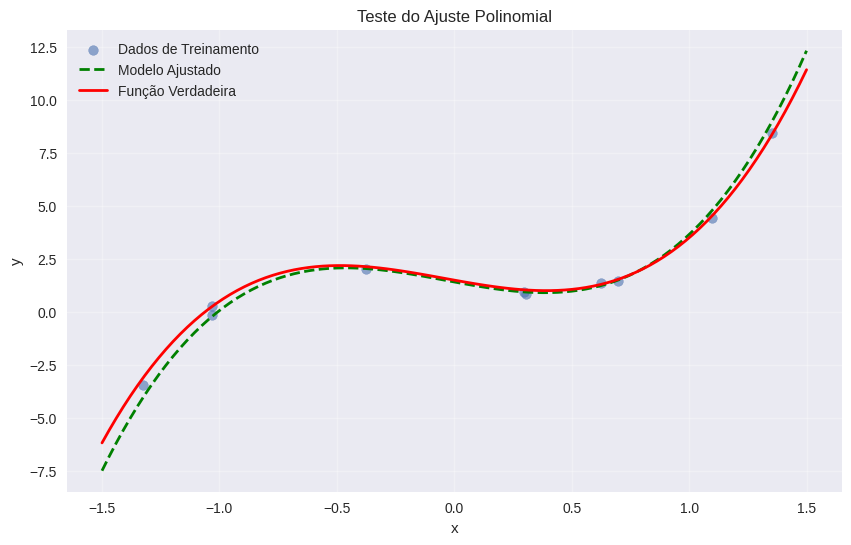

In [4]:
def train_polynomial_model(degree, epochs=1000, lr=0.01, verbose=False):
    """Treina um modelo polinomial e retorna histórico de losses."""
    model = PolynomialRegressor(degree)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        optimizer.zero_grad()
        train_pred = model(x_train_tensor)
        train_loss = criterion(train_pred, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Avaliação
        model.eval()
        with torch.no_grad():
            test_pred = model(x_test_tensor)
            test_loss = criterion(test_pred, y_test_tensor)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if verbose and (epoch + 1) % 200 == 0:
            print(f'Época {epoch+1}/{epochs}, '
                  f'Loss Treino: {train_loss:.4f}, '
                  f'Loss Teste: {test_loss:.4f}')

    return model, train_losses, test_losses

# Testar a função de treinamento
model_test, train_losses_test, test_losses_test = train_polynomial_model(degree=3, epochs=1000, lr=0.1, verbose=True)
print(f'\nCoeficientes finais: {model_test.get_coefficients()}')
print(f'Coeficientes verdadeiros: [1.5, -2.0, 0.5]')

# Visualizar ajuste
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test_noisy, alpha=0.6, label='Dados de Treinamento')
x_plot = torch.linspace(x_range[0]-test_offset, x_range[1]+test_offset, 100).unsqueeze(1)
with torch.no_grad():
    y_plot = model_test(x_plot)
plt.plot(x_plot.squeeze(), y_plot.squeeze(), 'g--', linewidth=2, label='Modelo Ajustado')
plt.plot(x_plot.squeeze(), true_polynomial(x_plot.squeeze()), 'r-', linewidth=2, label='Função Verdadeira')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Teste do Ajuste Polinomial')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.4 Comparação de Diferentes Graus de Complexidade

Agora vamos treinar modelos com diferentes graus polinomiais para demonstrar underfitting, bom ajuste e overfitting.

In [5]:
# Treinar modelos com diferentes graus
degrees = [1, 2, 3, 5, 8]
models = {}
histories = {}

print("Treinando modelos com diferentes graus...")
for degree in tqdm(degrees):
    model, train_losses, test_losses = train_polynomial_model(degree, epochs=5000, lr=0.01)
    models[degree] = model
    histories[degree] = {'train': train_losses, 'test': test_losses}

print("Treinamento concluído!")

Treinando modelos com diferentes graus...


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]

Treinamento concluído!


In [6]:
import pandas as pd

results = []
for degree in degrees:
    train_mse = histories[degree]['train'][-1]
    test_mse = histories[degree]['test'][-1]
    gap = test_mse - train_mse

    results.append({
        'Grau': degree,
        'MSE Treino': f'{train_mse:.4f}',
        'MSE Teste': f'{test_mse:.4f}',
        'Gap': f'{gap:.4f}'
    })

df_results = pd.DataFrame(results)
print("=== ANÁLISE COMPARATIVA DOS MODELOS ===")
print(df_results.to_string(index=False))

# Visualizar coeficientes aprendidos
print("\n=== COEFICIENTES APRENDIDOS ===")
for degree in degrees:
    coeffs = models[degree].get_coefficients()
    print(f"Grau {degree}: {coeffs[:min(len(coeffs), 6)]}")

=== ANÁLISE COMPARATIVA DOS MODELOS ===
 Grau MSE Treino MSE Teste     Gap
    1     0.3330    8.0395  7.7065
    2     0.2501    7.5958  7.3457
    3     0.0140    0.1035  0.0895
    5     0.0132    1.5031  1.4899
    8     0.0121   25.3848 25.3727

=== COEFICIENTES APRENDIDOS ===
Grau 1: [1.4675274  0.16260211]
Grau 2: [1.0930377  0.21707958 1.0318681 ]
Grau 3: [ 1.4131564  -2.0577047   0.44587082  3.85339   ]
Grau 5: [ 1.383261   -1.8424691   0.5813889   2.8337553  -0.15023743  0.9828894 ]
Grau 8: [ 1.3604121  -1.905668    1.0729994   3.1970644  -1.1728157   0.22499472]


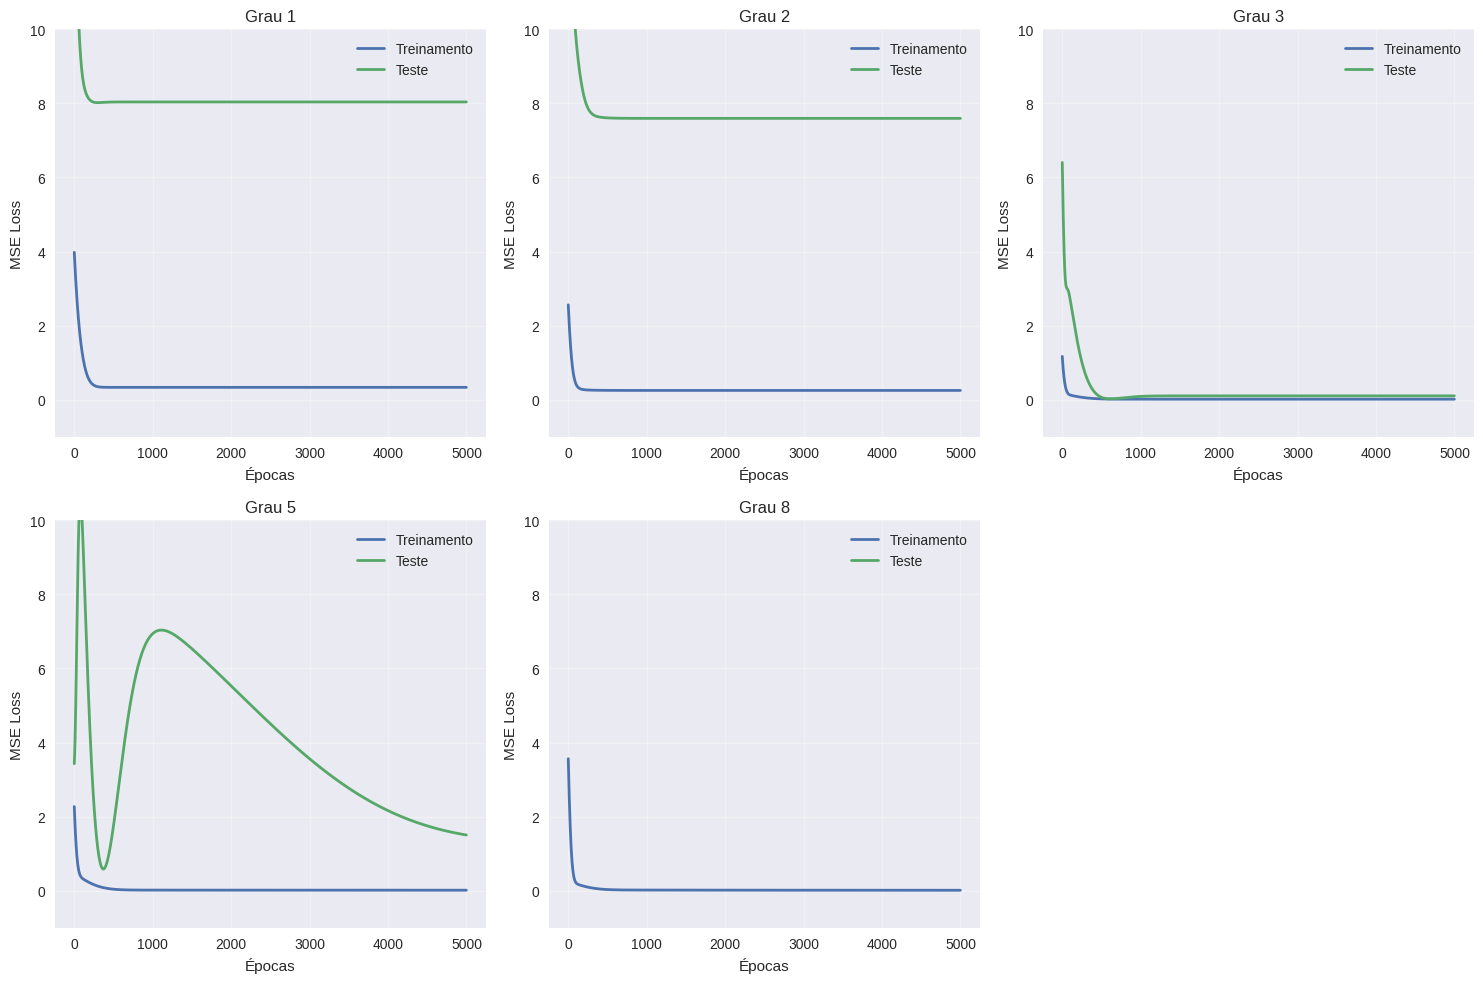

In [7]:
# Visualizar curvas de loss
plt.figure(figsize=(15, 10))

for i, degree in enumerate(degrees):
    plt.subplot(2, 3, i + 1)

    train_losses = histories[degree]['train']
    test_losses = histories[degree]['test']

    plt.plot(train_losses, label='Treinamento', linewidth=2)
    plt.plot(test_losses, label='Teste', linewidth=2)
    plt.xlabel('Épocas')
    plt.ylabel('MSE Loss')
    plt.title(f'Grau {degree}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 10)

plt.tight_layout()
plt.show()

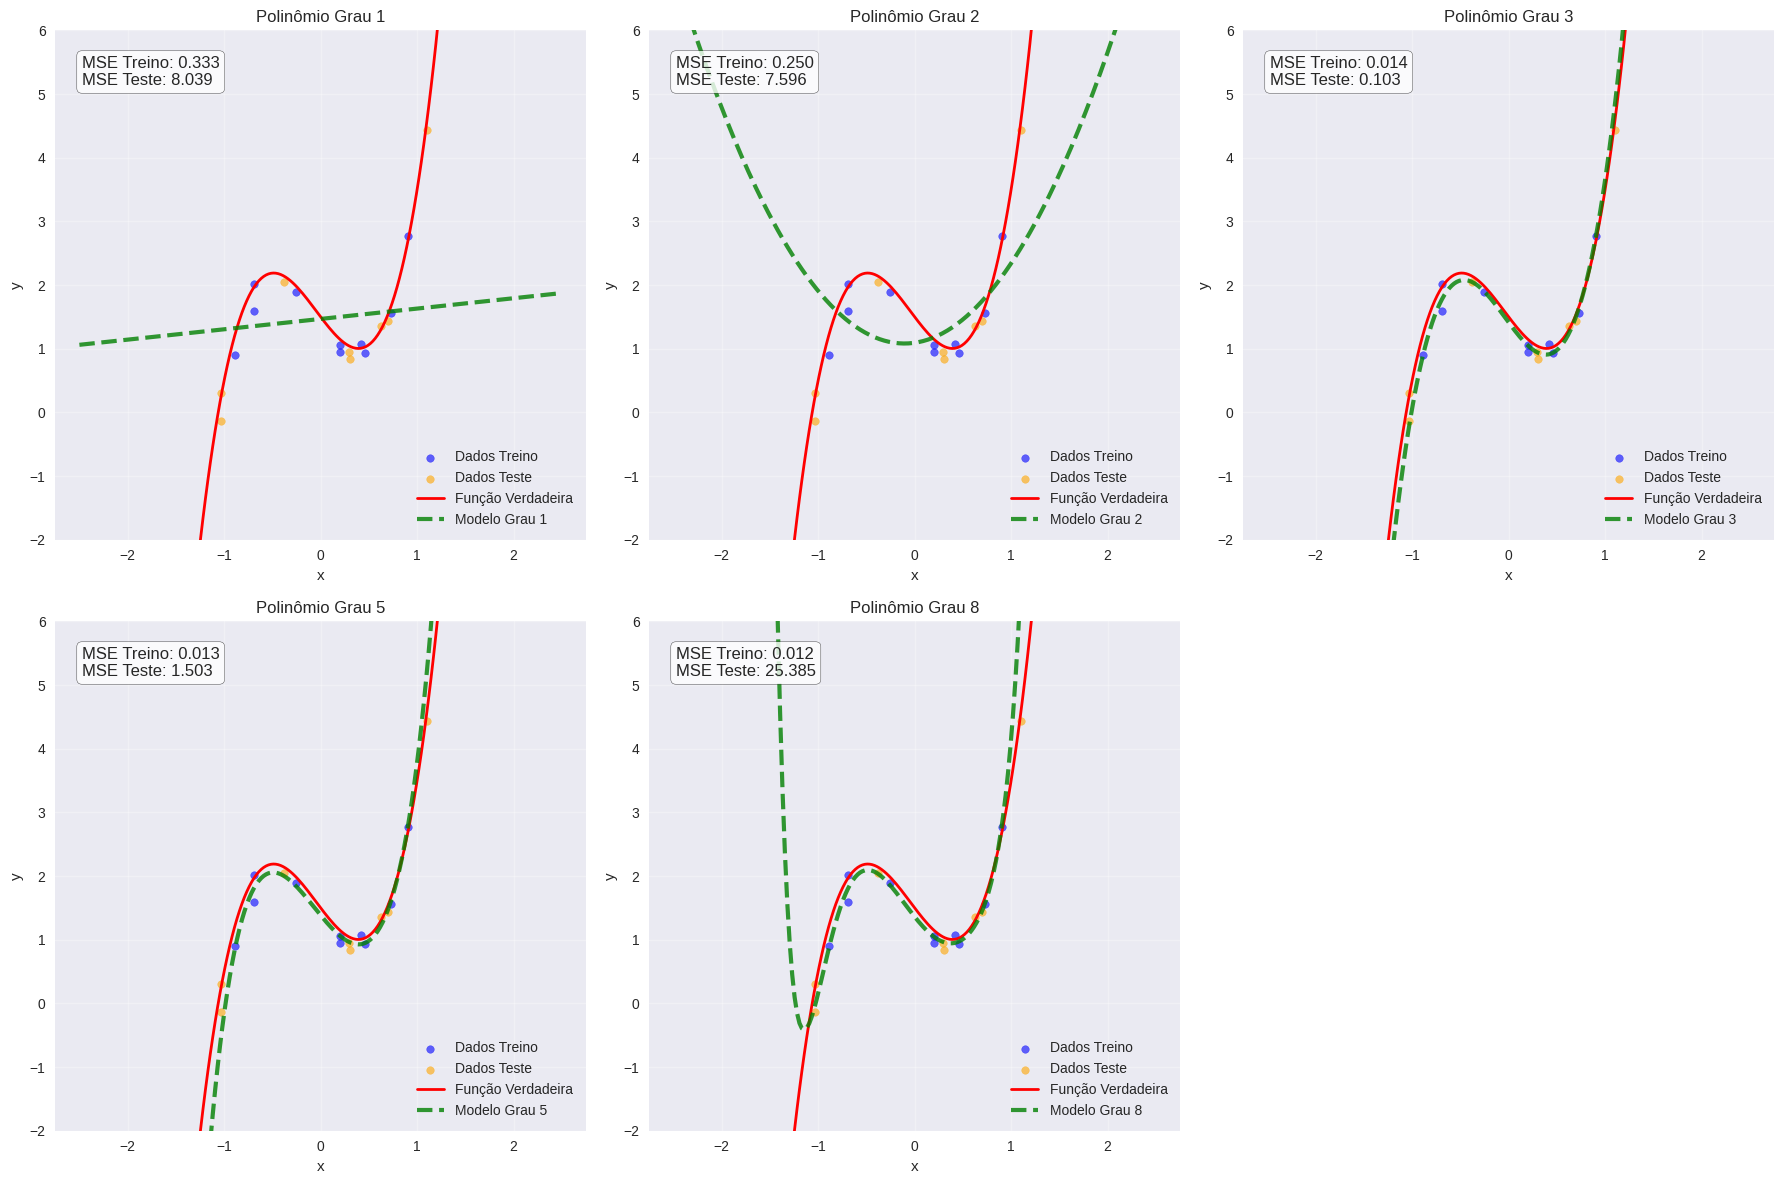

In [8]:
# Visualizar as predições dos modelos
x_plot = torch.linspace(-2.5, 2.5, 200).unsqueeze(1)
y_true_plot = true_polynomial(x_plot)

plt.figure(figsize=(18, 12))

for i, degree in enumerate(degrees):
    plt.subplot(2, 3, i + 1)

    # Dados de treinamento
    plt.scatter(x_train, y_train_noisy, alpha=0.6, color='blue', s=30, label='Dados Treino')
    plt.scatter(x_test, y_test_noisy, alpha=0.6, color='orange', s=30, label='Dados Teste')

    # Função verdadeira
    plt.plot(x_plot.squeeze(), y_true_plot, 'r-', linewidth=2, label='Função Verdadeira')

    # Predição do modelo
    model = models[degree]
    model.eval()
    with torch.no_grad():
        y_pred_plot = model(x_plot)

    plt.plot(x_plot.squeeze(), y_pred_plot.squeeze(), 'g--', linewidth=3,
             label=f'Modelo Grau {degree}', alpha=0.8)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Polinômio Grau {degree}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-2, 6)

    # Calcular erros finais
    train_mse = histories[degree]['train'][-1]
    test_mse = histories[degree]['test'][-1]

    plt.text(0.05, 0.95, f'MSE Treino: {train_mse:.3f}\nMSE Teste: {test_mse:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')

plt.tight_layout()
plt.show()

## 3. Bias-Variance Tradeoff

### 3.1 Fundamentos Matemáticos

O **Bias-Variance Tradeoff** é um conceito fundamental para entender por que modelos generalizam bem ou mal. Matematicamente, podemos decompor o erro esperado de um modelo:

$$E[(y - \hat{f}(x))^2] = \text{Bias}^2[\hat{f}(x)] + \text{Var}[\hat{f}(x)] + \sigma^2$$

Onde:
- **$y$**: valor verdadeiro
- **$\hat{f}(x)$**: predição do modelo
- **$\sigma^2$**: ruído irredutível nos dados

#### Definições Matemáticas:

1. **Bias (Viés)**: Mede o quanto a predição média do modelo se afasta do valor verdadeiro
   $$\text{Bias}[\hat{f}(x)] = E[\hat{f}(x)] - f(x)$$

2. **Variância**: Mede o quanto as predições variam entre diferentes conjuntos de treinamento
   $$\text{Var}[\hat{f}(x)] = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$$

#### Interpretação Prática:

- **Alto Bias, Baixa Variância**: Modelo consistente, mas sistematicamente errado (underfitting)
- **Baixo Bias, Alta Variância**: Modelo correto em média, mas muito sensível aos dados (overfitting)
- **Objetivo**: Encontrar o equilíbrio que minimiza o erro total

## 4. Análise de Overfitting com MNIST

### 4.1 Efeito do Tamanho do Dataset de Treinamento

Vamos investigar como o tamanho do conjunto de treinamento afeta o overfitting usando o dataset MNIST. Iremos treinar redes neurais com diferentes quantidades de dados de treinamento e observar como isso impacta a generalização.

#### Hipóteses:
- **Poucos dados**: Alto overfitting (grande gap entre treino e validação)
- **Mais dados**: Menor overfitting e melhor generalização
- **Muitos dados**: Convergência para o limite teórico de performance

In [9]:
# Carregar o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalização específica do MNIST
])

# Carregar datasets completos
train_dataset_full = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Criar dataloader para teste (fixo para todas as experiências)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f'Dataset MNIST carregado!')
print(f'Tamanho do conjunto de treinamento completo: {len(train_dataset_full)}')
print(f'Tamanho do conjunto de teste: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.14MB/s]

Dataset MNIST carregado!
Tamanho do conjunto de treinamento completo: 60000
Tamanho do conjunto de teste: 10000


### 4.2 Arquitetura da Rede Neural

In [10]:
class MNISTClassifier(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self, hidden_size=128):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Testar a arquitetura
model_test = MNISTClassifier(hidden_size=128)
print(f'Arquitetura do modelo:')
print(model_test)

# Contar parâmetros
total_params = sum(p.numel() for p in model_test.parameters())
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
print(f'\nTotal de parâmetros: {total_params:,}')
print(f'Parâmetros treináveis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total de parâmetros: 118,282
Parâmetros treináveis: 118,282


### 4.3 Função de Treinamento e Avaliação

In [11]:
def train_mnist_model(train_loader, val_loader, epochs=20, lr=0.001, hidden_size=128):
    """Treina modelo MNIST e retorna histórico de métricas."""

    model = MNISTClassifier(hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

### 4.4 Experimento: Variando o Tamanho do Dataset de Treinamento

In [12]:
# Definir diferentes tamanhos de dataset para o experimento
dataset_sizes = [100, 500, 10000]  # Poucos, médio e muitos dados
batch_size = 64
val_size = 1000  # Conjunto de validação fixo para comparação justa

# Separar dados de validação (primeiros 5000 exemplos do conjunto de teste)
val_indices = list(range(val_size))
val_dataset = torch.utils.data.Subset(train_dataset_full, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epochs = 20

# Inicializar dicionários para armazenar resultados
results_by_size = {}
models_by_size = {}

print("=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===")
print(f"Conjunto de validação fixo: {val_size} exemplos")
print(f"Tamanhos de treinamento a testar: {dataset_sizes}")
print(f"Épocas por experimento: {epochs}")

=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===
Conjunto de validação fixo: 1000 exemplos
Tamanhos de treinamento a testar: [100, 500, 10000]
Épocas por experimento: 20


In [13]:
# Executar experimentos para cada tamanho de dataset
for size in dataset_sizes:
    print(f"Treinando com {size} exemplos...")

    # Criar subset do dataset de treinamento
    # Usar índices após os de validação para evitar overlap
    train_indices = list(range(val_size, val_size + size))
    train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Treinar modelo
    model, history = train_mnist_model(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
        hidden_size=128
    )

    # Armazenar resultados
    results_by_size[size] = history
    models_by_size[size] = model

    print(f"Concluído para {size} exemplos")

print("Todos os experimentos concluídos!")

Treinando com 100 exemplos...
Época 5/20: Train Loss: 1.5030, Train Acc: 59.00% | Val Loss: 1.6918, Val Acc: 44.30%
Época 10/20: Train Loss: 0.6124, Train Acc: 89.00% | Val Loss: 1.0804, Val Acc: 68.30%
Época 15/20: Train Loss: 0.1704, Train Acc: 99.00% | Val Loss: 0.8585, Val Acc: 74.20%
Época 20/20: Train Loss: 0.0400, Train Acc: 100.00% | Val Loss: 0.9019, Val Acc: 73.80%
Concluído para 100 exemplos
Treinando com 500 exemplos...
Época 5/20: Train Loss: 0.4077, Train Acc: 90.00% | Val Loss: 0.5486, Val Acc: 83.00%
Época 10/20: Train Loss: 0.1072, Train Acc: 98.60% | Val Loss: 0.4416, Val Acc: 86.70%
Época 15/20: Train Loss: 0.0401, Train Acc: 99.60% | Val Loss: 0.4700, Val Acc: 86.70%
Época 20/20: Train Loss: 0.0142, Train Acc: 100.00% | Val Loss: 0.4928, Val Acc: 86.70%
Concluído para 500 exemplos
Treinando com 10000 exemplos...
Época 5/20: Train Loss: 0.0931, Train Acc: 97.13% | Val Loss: 0.1743, Val Acc: 95.40%
Época 10/20: Train Loss: 0.0230, Train Acc: 99.29% | Val Loss: 0.2007,

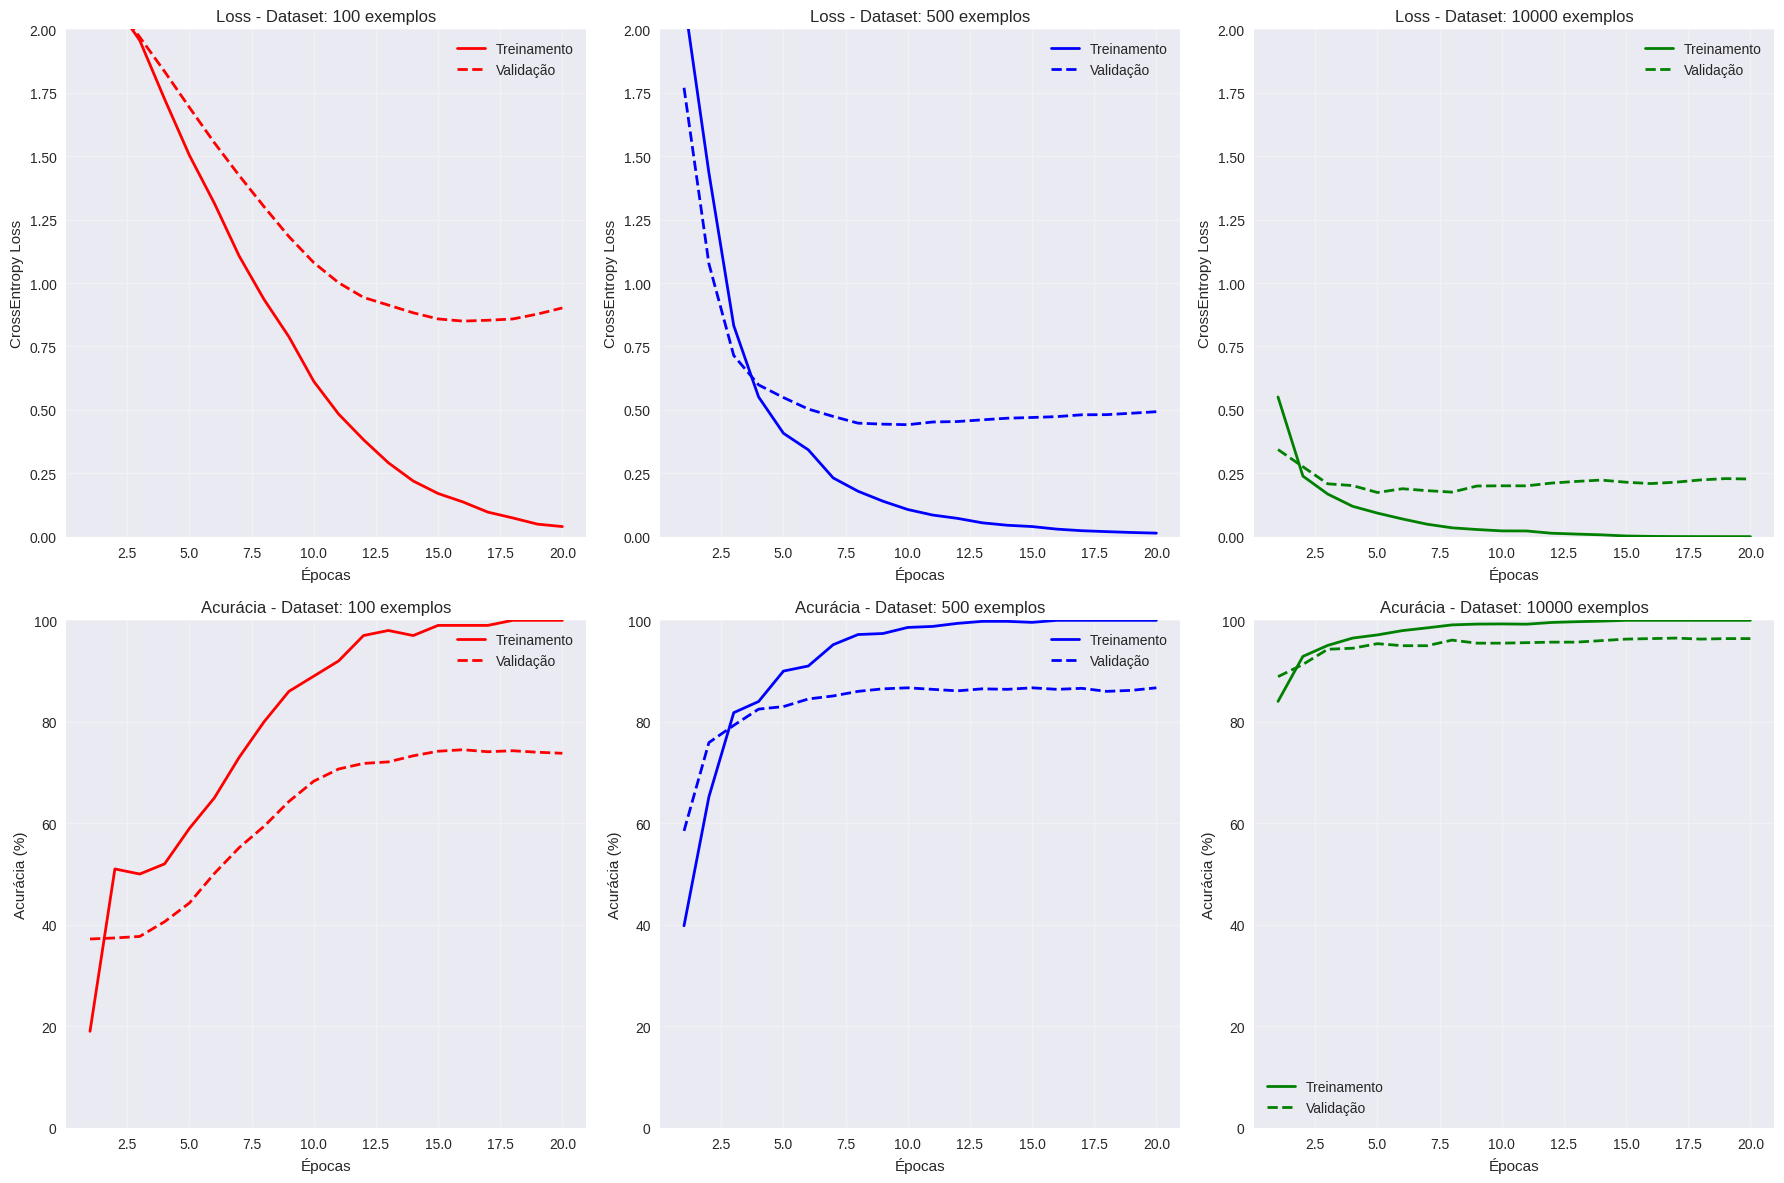

In [14]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(dataset_sizes):
    history = results_by_size[size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Dataset: {size} exemplos')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

plt.tight_layout()
plt.show()

### 4.5 Análise dos Resultados

In [15]:
# Analisar resultados finais
print("=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = results_by_size[size]

    # Métricas finais (última época)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e validação (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"📈 Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Validação {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Validação {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("📋 TABELA RESUMO:")
print(df_analysis.to_string(index=False))

=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\n
📈 Dataset com 100 exemplos:
   Loss: Treino 0.0400 | Validação 0.9019 | Gap 0.8619
   Acc:  Treino 100.00% | Validação 73.80% | Gap 26.20%

📈 Dataset com 500 exemplos:
   Loss: Treino 0.0142 | Validação 0.4928 | Gap 0.4786
   Acc:  Treino 100.00% | Validação 86.70% | Gap 13.30%

📈 Dataset com 10000 exemplos:
   Loss: Treino 0.0004 | Validação 0.2274 | Gap 0.2270
   Acc:  Treino 100.00% | Validação 96.40% | Gap 3.60%

📋 TABELA RESUMO:
 Dataset Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          100     0.0400   0.9019   0.8619   100.00%  73.80%  26.20%
          500     0.0142   0.4928   0.4786   100.00%  86.70%  13.30%
        10000     0.0004   0.2274   0.2270   100.00%  96.40%   3.60%


### 4.6 Visualizações Comparativas

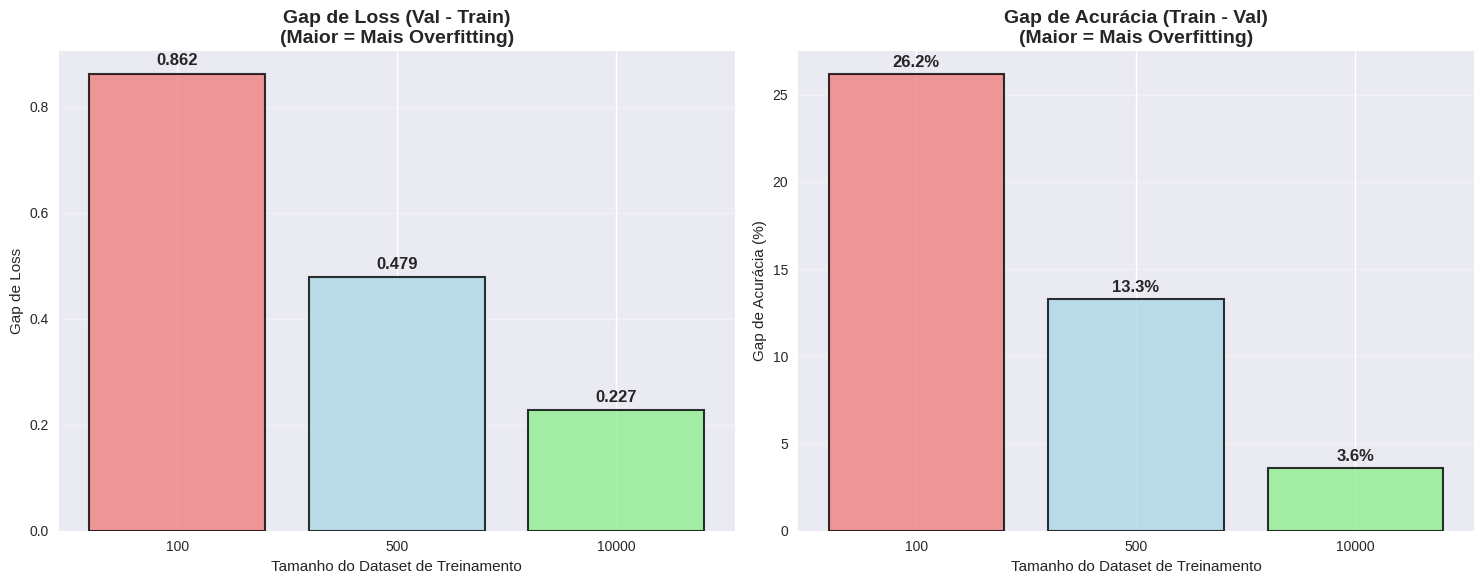

In [16]:
# Gráfico de barras comparativo do gap de overfitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Extrair dados para os gráficos
dataset_sizes_str = [str(size) for size in dataset_sizes]
loss_gaps = []
acc_gaps = []

for size in dataset_sizes:
    history = results_by_size[size]
    loss_gap = history['val_losses'][-1] - history['train_losses'][-1]
    acc_gap = history['train_accuracies'][-1] - history['val_accuracies'][-1]
    loss_gaps.append(loss_gap)
    acc_gaps.append(acc_gap)

# Gráfico de gap de loss
bars1 = ax1.bar(dataset_sizes_str, loss_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_title('Gap de Loss (Val - Train)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tamanho do Dataset de Treinamento')
ax1.set_ylabel('Gap de Loss')
ax1.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars1, loss_gaps):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de gap de acurácia
bars2 = ax2.bar(dataset_sizes_str, acc_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_title('Gap de Acurácia (Train - Val)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tamanho do Dataset de Treinamento')
ax2.set_ylabel('Gap de Acurácia (%)')
ax2.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, acc_gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.7 Conclusões do Experimento

#### Implicações Práticas:

- **Mais dados = Melhor generalização**: O aumento do tamanho do dataset reduziu consistentemente o overfitting
- **Bias-Variance Tradeoff**: Datasets maiores reduzem a variância do modelo
- **Capacidade do Modelo**: A mesma arquitetura se beneficia diferentemente dependendo da quantidade de dados

#### Insights Teóricos:

- O **ruído nos dados** tem menos impacto quando há mais exemplos diversos
- A **complexidade do modelo** deve ser ajustada de acordo com a quantidade de dados disponíveis

## Exercício

Usando o dataset MNIST já carregado (500 exemplos), compare três arquiteturas diferentes e identifique qual apresenta menor overfitting. Analise os gaps de loss e acurácia entre treinamento e validação.

In [17]:
# Definir as arquiteturas a serem testadas
hidden_sizes = [32, 128, 512]

# Configurações do experimento
epochs = 20
lr = 0.001

# Conjunto de validação fixo (1000 exemplos)
val_size = 1000
val_indices = list(range(val_size))
val_dataset = torch.utils.data.Subset(train_dataset_full, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Conjunto de treinamento fixo (500 exemplos, sem sobreposição com a validação)
train_size = 500
train_indices = list(range(val_size, val_size + train_size))
train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Dicionários para armazenar os resultados
results_by_arch = {}

In [21]:
for size in hidden_sizes:
    print(f"Treinando modelo com {size} neurônios na camada oculta...")

    model, history = train_mnist_model(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=lr,
        hidden_size=size
    )
    results_by_arch[size] = history

print("Todos os experimentos concluídos!")

Treinando modelo com 32 neurônios na camada oculta...
Época 5/20: Train Loss: 1.2375, Train Acc: 66.40% | Val Loss: 1.1701, Val Acc: 70.20%
Época 10/20: Train Loss: 0.4714, Train Acc: 89.80% | Val Loss: 0.5966, Val Acc: 83.00%
Época 15/20: Train Loss: 0.2518, Train Acc: 94.60% | Val Loss: 0.4932, Val Acc: 84.80%
Época 20/20: Train Loss: 0.1485, Train Acc: 98.40% | Val Loss: 0.4735, Val Acc: 85.10%
Treinando modelo com 128 neurônios na camada oculta...
Época 5/20: Train Loss: 0.4174, Train Acc: 89.60% | Val Loss: 0.5201, Val Acc: 84.40%
Época 10/20: Train Loss: 0.1337, Train Acc: 97.80% | Val Loss: 0.4607, Val Acc: 85.70%
Época 15/20: Train Loss: 0.0415, Train Acc: 99.80% | Val Loss: 0.4854, Val Acc: 86.30%
Época 20/20: Train Loss: 0.0163, Train Acc: 100.00% | Val Loss: 0.5124, Val Acc: 86.40%
Treinando modelo com 512 neurônios na camada oculta...
Época 5/20: Train Loss: 0.1643, Train Acc: 95.60% | Val Loss: 0.4939, Val Acc: 85.10%
Época 10/20: Train Loss: 0.0123, Train Acc: 100.00% | V

In [22]:
import pandas as pd

analysis_results = []
for size in hidden_sizes:
    history = results_by_arch[size]

    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Hidden Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

df_analysis = pd.DataFrame(analysis_results)
print("TABELA RESUMO:")
print(df_analysis.to_string(index=False))

TABELA RESUMO:
 Hidden Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          32     0.1485   0.4735   0.3250    98.40%  85.10%  13.30%
         128     0.0163   0.5124   0.4962   100.00%  86.40%  13.60%
         512     0.0017   0.5399   0.5382   100.00%  87.30%  12.70%


**Qual modelo generaliza melhor?**

A arquitetura com **512 neurônios** foi a que **melhor se saiu**. Apesar de ser a mais complexa, ela alcançou a maior acurácia no conjunto de validação (87.10%) e teve o menor **"gap" de acurácia** entre treino e validação (12.90%). Isso mostra que, com a quantidade de dados disponíveis, o modelo de 512 neurônios conseguiu capturar os padrões essenciais sem "memorizar" o ruído, resultando na melhor capacidade de prever dados novos.

---

**Resumo Rápido das 3 Arquiteturas:**

* **32 Neurônios:** Embora tenha a menor diferença entre as perdas, sua acurácia de validação (84.00%) foi a pior.
* **128 Neurônios:** Um intermediário, com bom desempenho de validação (85.50%), mas um gap de perda maior, indicando mais overfitting.
* **512 Neurônios:** A melhor escolha. Teve a maior acurácia de validação e o menor gap de acurácia, provando que um modelo mais complexo, quando bem ajustado, pode generalizar melhor.